In [125]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')


In [126]:
oil=pd.read_csv("C:/Users/Ujjwal/OneDrive/Documents/AEP_hourly.csv", index_col=[0], parse_dates=[0])
oil


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


In [127]:
y_col = "AEP_MW"

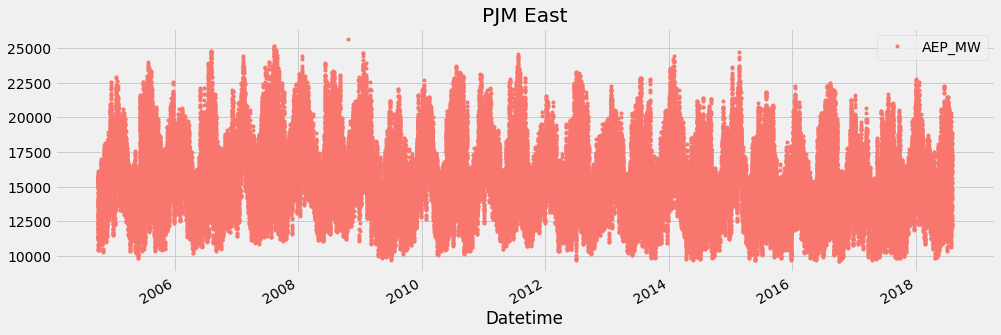

In [128]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_= oil.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

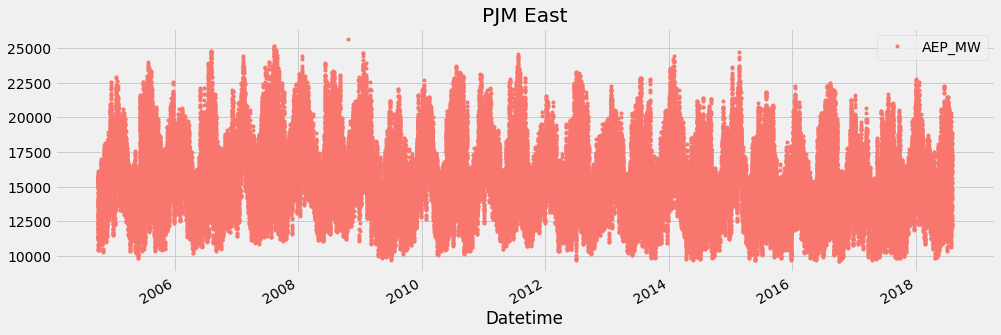

In [129]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = oil.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')


In [130]:
split_date = '01-Jan-2015'
oil_train = oil.loc[oil.index <= split_date].copy()
oil_test =oil.loc[oil.index > split_date].copy()


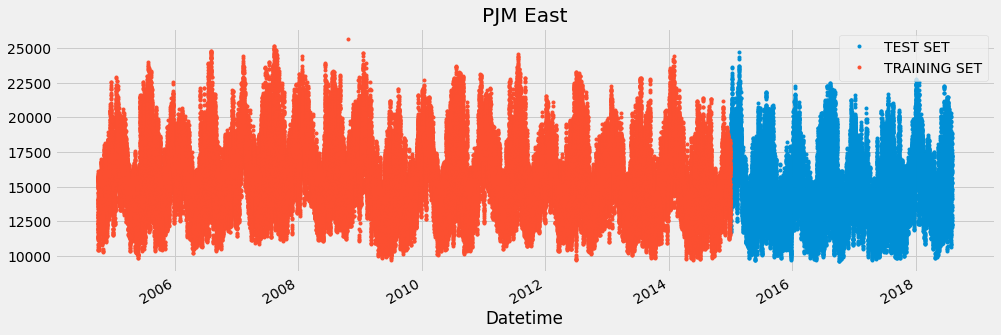

In [131]:
_ = oil_test .rename(columns={y_col: 'TEST SET'}) .join(oil_train.rename(columns={y_col: 'TRAINING SET'}), how='outer') .plot(figsize=(15,5), title='PJM East', style='.')


In [132]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [133]:
X_train, y_train = create_features(oil_train, label=y_col)
X_test, y_test = create_features(oil_test, label=y_col)

C:\Users\Ujjwal\AppData\Local\Temp\ipykernel_8064\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\Ujjwal\AppData\Local\Temp\ipykernel_8064\256030966.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [134]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\Ujjwal\miniconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

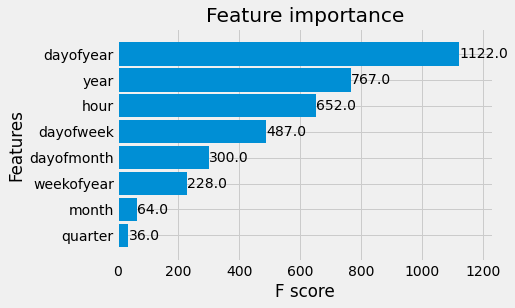

In [135]:
_ = plot_importance(reg, height=0.9)

In [136]:
oil_test['MW_Prediction'] = reg.predict(X_test)
oil_all = pd.concat([oil_test, oil_train], sort=False)

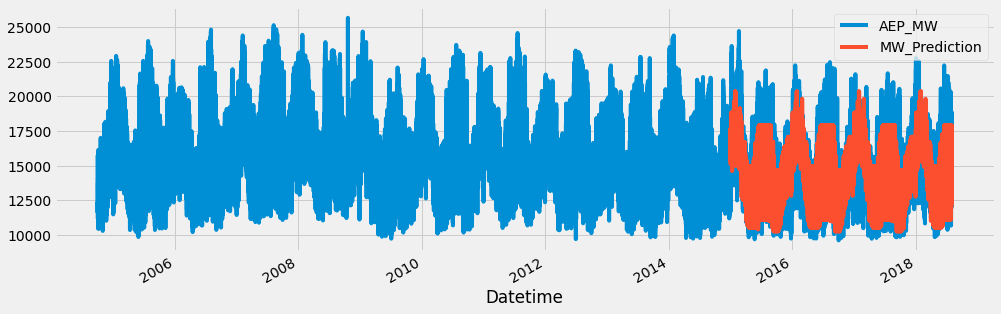

In [137]:
_ = oil_all[[y_col,'MW_Prediction']].plot(figsize=(15, 5))


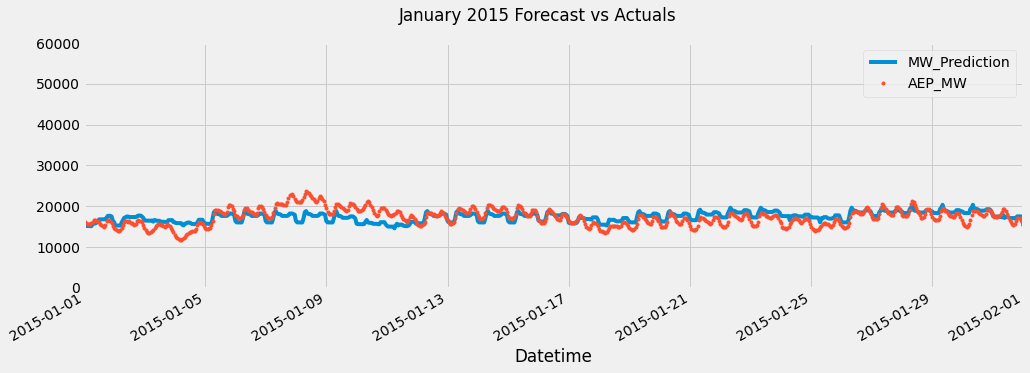

In [138]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle(' Forecast vs Actuals')


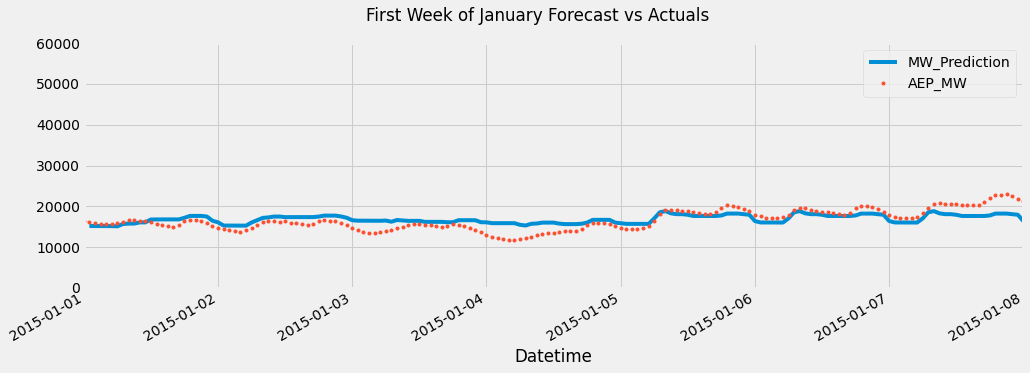

In [139]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')


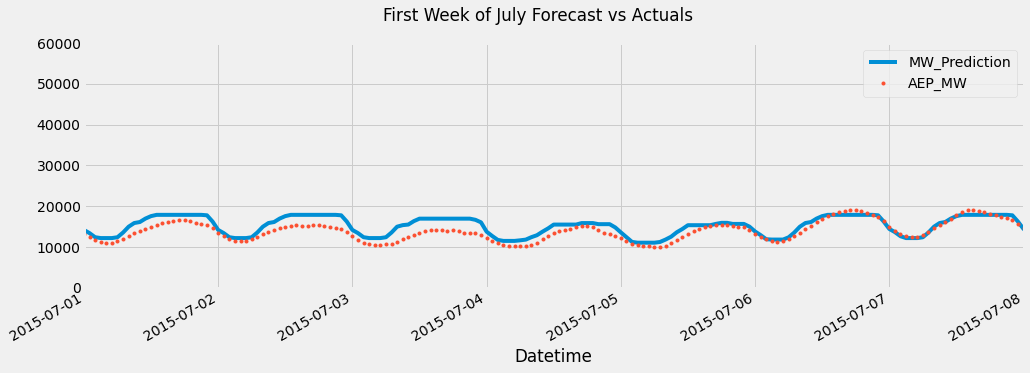

In [140]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [141]:
mean_squared_error(y_true=oil_test[y_col],
    y_pred=oil_test['MW_Prediction'])

2604129.5553274993

In [142]:
mean_absolute_error(y_true=oil_test[y_col],
    y_pred=oil_test['MW_Prediction'])

1237.3640072963715

In [143]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [144]:
mean_absolute_percentage_error(y_true=oil_test[y_col],
    y_pred=oil_test['MW_Prediction'])


8.270429862369676

In [145]:
oil_test['error'] = oil_test[y_col] - oil_test['MW_Prediction']
oil_test['abs_error'] = oil_test['error'].apply(np.abs)
error_by_day = oil_test.groupby(['year','month','dayofmonth']).mean()[[y_col,'MW_Prediction','error','abs_error']]


In [146]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)


AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2017 1     22          12295.541667   16617.234375 -4321.693319  4321.693319
           21          12891.375000   16997.955078 -4106.580526  4106.580526
     2     23          13437.333333   17466.052734 -4028.720256  4028.720256
     1     23          14428.125000   18355.421875 -3927.295898  3927.295898
     2     24          13111.625000   17027.525391 -3915.900187  3915.900187
           22          13582.750000   17466.052734 -3883.303589  3883.303589
2018 1     22          14509.750000   18355.421875 -3845.670898  3845.670898
2015 12    25          11078.041667   14744.424805 -3666.382731  3666.382731
2017 1     25          14862.458333   18526.003906 -3663.545410  3663.545410
2016 7     4           12048.000000   15698.821289 -3650.821615  3650.821615

In [147]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     20          22047.041667   16496.251953  5550.789307  5550.789307
           19          22249.500000   16979.966797  5269.532389  5269.532389
2018 1     6           20847.833333   15837.413086  5010.420003  5010.420003
           7           19803.375000   15390.620117  4412.754720  4412.754720
2015 1     8           21873.333333   17497.107422  4376.226562  4376.226562
2017 1     22          12295.541667   16617.234375 -4321.693319  4321.693319
     12    28          19396.291667   15211.703125  4184.588582  4184.588582
2015 2     16          21129.791667   16984.783203  4145.009155  4145.009155
2017 1     21          12891.375000   16997.955078 -4106.580526  4106.580526
2018 1     2           20938.500000   16871.527344  4066.973470  4066.973470

In [148]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2017 11    8           14602.750000   14602.919922   -0.169474  203.321248
     10    28          12723.833333   12744.483398  -20.650431  214.592570
2018 6     23          14103.291667   14031.885742   71.405680  256.993490
     4     28          12237.583333   12252.085938  -14.502563  259.252157
2015 9     30          13556.583333   13707.728516 -151.145549  264.775920
2017 4     1           12569.208333   12430.785156  138.423665  267.845052
     11    16          14938.958333   14918.449219   20.509603  279.187012
2016 12    12          15836.333333   15871.387695  -35.054525  283.551107
     3     5           14801.166667   14795.866211    5.300618  290.299398
     12    2           15458.250000   15604.341797 -146.091756  291.837443

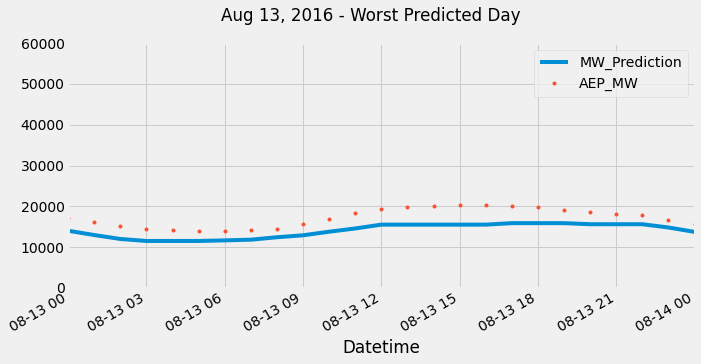

In [149]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

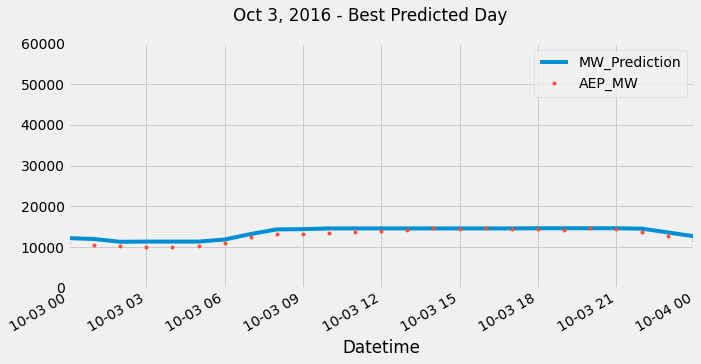

In [150]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

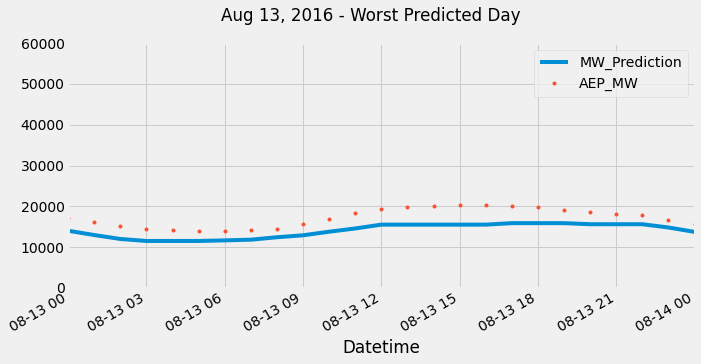

In [151]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = oil_all[['MW_Prediction',y_col]].plot(ax=ax,style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')
plt.savefig('')